# Intro

So you need to build a table model? 3ML via astromodels provides you with nice facilities to accomplish this task. But often, we need to interface with computationally expensive simulations and require many runs of these simulations. This is a very generic task and Ron Swanson wants to make things as simple as possible for you. Making things complicated is annoying.

![alt text](https://raw.githubusercontent.com/grburgess/ronswanson/master/docs/media/mad.jpg)

## Example with a Band function

Let's say we want to make a table model from a Band function.

We pick a parameter grid and a grid of energies for our simulation. We can enter these in a YAML file:

```yaml
alpha:
  custom: no
  vmin: -1
  vmax: 0
  scale: "linear"
  n_points: 10

beta:
  custom: no
  vmin: -3
  vmax: -2
  scale: "linear"
  n_points: 10

epeak:
  custom: yes
  values: [50., 69.74 , 97.29, 135.72, 189.32, 264.097, 368.4, 513.9, 716.87, 1000.]

energy_grid:
  custom: no
  vmin: 10
  vmax: 1000
  scale: "log"
  n_points: 50


```

As can be seen, we can specify the parameter/energy grids ourselves, or we can specify their ranges and let it be done for us.




### The Simulation class

Now we need to make a class for the simulation. We will inherit from the simulation class and specify a `_run_call` function that tells the program how to run the simulation for a given set of parameters. This function **must** return an array of photon fluxes for the given energies.



In [1]:
from typing import Dict

import numpy as np
from astromodels import Band
import ronswanson as dukesilver


class BandSimulation(dukesilver.Simulation):
    def __init__(
        self,
        simulation_id: int,
        parameter_set: Dict[str, float],
        energy_grid: np.ndarray,
        out_file: str,
    ) -> None:
        super().__init__(simulation_id, parameter_set, energy_grid, out_file)

    def _run_call(self) -> np.ndarray:

        b = Band(
            K=1,
            alpha=self._parameter_set["alpha"],
            beta=self._parameter_set["beta"],
            xp=self._parameter_set["epeak"],
        )

        return b(self._energy_grid)

[WARNING ] The naima package is not available. Models that depend on it will not be available


[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.


[WARNING ] The ebltable package is not available. Models that depend on it will not be available


Now we need to tell the simulation builder a few things so it can construct our files for us. We have stored this YAML file in the repo itself. You should use your own!

The `SimulationBuilder` class takes a parameter grid, the name of the file that will be created, the import line for the custom simulation class, the number of cores and nodes to execute on.

In [2]:
from ronswanson.utils.package_data import get_path_of_data_file


file_name = get_path_of_data_file("test_params.yml")


# create a parameter grid from our file
pg = dukesilver.ParameterGrid.from_yaml(file_name)

# create a simulation builder
sb = dukesilver.SimulationBuilder(
    pg,
    "database.h5",
    "from ronswanson.band_simulation import BandSimulation as Simulation",
    n_cores=8,
    n_nodes=None,
)

Now a python file will be written to the disk which you can run to create your simulation runs. we can have a look at the file.

```
from ronswanson.band_simulation import BandSimulation as Simulation
from joblib import Parallel, delayed
from ronswanson import ParameterGrid

pg = ParameterGrid.from_yaml('/Users/jburgess/coding/projects/ronswanson/parameters.yml')
def func(i):
	params = pg.at_index(i)
	simulation = Simulation(i, params, pg.energy_grid.grid,'/Users/jburgess/coding/projects/ronswanson/database.h5')
	simulation.run()

iteration = [i for i in range(0, pg.n_points)]

Parallel(n_jobs=8)(delayed(func)(i) for i in iteration)

```

Now this simply uses `joblib` to farm out the iterations over the parameter combinations. If iterations are to also be divided across HPC nodes, the python script will be modified and an associated `SLURM` script will be generated.


### The Database



Upon running the script, an HDF5 database of the runs is created which contains all the information needed to build a table model in `3ML`.

In [3]:
from ronswanson.utils.package_data import get_path_of_data_file
from ronswanson import Database

In [4]:
db = Database.from_file(get_path_of_data_file("test_database.h5"))
db.parameter_ranges

OrderedDict([('alpha',
              array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
                      0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])),
             ('beta',
              array([-3.        , -2.88888889, -2.77777778, -2.66666667, -2.55555556,
                     -2.44444444, -2.33333333, -2.22222222, -2.11111111, -2.        ])),
             ('epeak',
              array([  50.        ,   69.7475397 ,   97.29438588,  135.72088083,
                      189.32395047,  264.09759503,  368.40314986,  513.9042664 ,
                      716.87116444, 1000.        ]))])

Now we can use the database to construct and save a table model for `3ML`

In [5]:
table_model = db.to_3ml("my_model", "a new model for 3ML")
table_model

[WARNING ] Energy unit is not a Quantity instance, so units has not been provided. Using keV.


* description: a new model for 3ML
  * formula: n.a.
  * parameters:
    * K:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * scale:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * alpha:
      * value: 0.0
      * desc: None
      * min_value: -1.0
      * max_value: 1.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * beta:
      * value: -2.5
      * desc: None
      * min_value: -3.0
      * max_value: -2.0
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true
    * epeak:
      * value: 226.71077275
      * desc: None
      * min_value: 50.0
      * max_value: 1000.0
      * unit: ''
      * is_normalization: false
      * delta: 22.671077275000002
      * free: true

In [6]:
import matplotlib.pyplot as plt
from astromodels import Band

%matplotlib inline

We can compare our table model with the Band function.

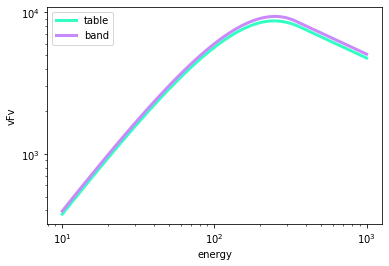

In [7]:
ene = np.geomspace(10, 1000, 100)

b = Band()
b.alpha = -0.6
b.beta = -2.5
b.xp = 250
b.K = 1.05

table_model.alpha = -0.6
table_model.beta = -2.5
table_model.epeak = 250


fig, ax = plt.subplots()

ax.loglog(
    ene, ene**2 * table_model(ene), color='#33FFC4', lw=3, label="table"
)
ax.loglog(ene, ene**2 * b(ene), color='#C989FB', lw=3, label="band")

ax.set(xlabel="energy", ylabel="vFv")

ax.legend()

Great! That was way easier than programming everything yourself.

![alt text](https://raw.githubusercontent.com/grburgess/ronswanson/master/docs/media/happy.jpeg)


Suppose we did not want to use all the values in the parameter ranges we have simulated. Bigger interpolation tables take up memory when fitting.

We can select a subset of the parameter ranges when building the table

In [8]:
selection = {}
selection['alpha'] = dict(vmax=0)
selection['epeak'] = dict(vmin=200, vmax=700)

table_model_small = db.to_3ml(
    "my_model_small", "a new model for 3ML", **selection
)
table_model_small

[WARNING ] Energy unit is not a Quantity instance, so units has not been provided. Using keV.


* description: a new model for 3ML
  * formula: n.a.
  * parameters:
    * K:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * scale:
      * value: 1.0
      * desc: None
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * alpha:
      * value: -0.5555555555555556
      * desc: None
      * min_value: -1.0
      * max_value: -0.11111111111111116
      * unit: ''
      * is_normalization: false
      * delta: 0.05555555555555556
      * free: true
    * beta:
      * value: -2.5
      * desc: None
      * min_value: -3.0
      * max_value: -2.0
      * unit: ''
      * is_normalization: false
      * delta: 0.25
      * free: true
    * epeak:
      * value: 368.40314986
      * desc: None
      * min_value: 264.09759503
      * max_value: 513.9042664
      * unit: ''
      * is_normalization: false
      * delta: 36.840314986
      * free: true

Awesome! Now go enjoy your weekend.

![alt text](https://raw.githubusercontent.com/grburgess/ronswanson/master/docs/media/enjoy.jpg)